# Use case example for data exploration and analysis 

Our data: [100 most spoken languages around the world from Kaggle](https://www.kaggle.com/narmelan/100-most-spoken-languages-around-the-world)

Our workflow:

0. Download the data and adapt the variable PATH_TO_DATA
1. Understand the problem
2. Visualize to find the answers
3. Report the findings

## 0. Download the data and adapt the variable PATH_TO_DATA

In [5]:

# Import libraries 
import pandas as pd
import seaborn as sns
import circlify
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from decouple import config
from numpy import nan
from matplotlib.cm import get_cmap
from matplotlib.colors import rgb2hex

# Set the data path and initiate the dataframe
PATH_TO_DATA = config("PATH_TO_DATA")
data = pd.read_csv(PATH_TO_DATA)

## 1. Understand the problem
Here we want to check our understanding of the raw data as well as which questions we are trying to answer with them. Main questions are: 
- What is the meaning of each variable/column in the real world?
- Can potentially interesting variables be generated from the existing ones?
- When and how were the data collected?
- Is the sample size enough to draw generalizations? 
- What are the research/business questions that can be tackled based on those data? 

Let's consider each of those aspects with the following first steps of data exploration.

In [6]:
# Global descriptive information on the data
data.info()
print("")
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Language         100 non-null    object 
 1   Total Speakers   100 non-null    int64  
 2   Native Speakers  96 non-null     float64
 3   Origin           100 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ KB



,Language,Total Speakers,Native Speakers,Origin
0,English,1132366680,379007140.0,Indo-European
1,Mandarin Chinese,1116596640,917868640.0,Sino-Tibetan
2,Hindi,615475540,341208640.0,Indo-European
3,Spanish,534335730,460093030.0,Indo-European
4,French,279821930,77177210.0,Indo-European


We identify 4 variables whom 2 numerical and 2 categorical for a total of 100 samples. Apparently a few missing data as indicated by the "Non-Null Count". Regarding the meaning of each variables:
- **Language**: object type containing the English name of each language 
- **Total Speakers**: int type measuring the number of speakers for each language which inludes both native and non-native speakers
- **Native Speakers**: float type representing the number of people whom the mother tongue is the associated language on the same row
- **Origin**: object type describing the [family origin group of each language](https://en.wikipedia.org/wiki/Language_family)

We noticed that the simple transformation $Total\;Speakers - Native\;Speakers$ will give us access to the number of non-native speakers to extend the analysis. From the [metadata](https://www.kaggle.com/narmelan/100-most-spoken-languages-around-the-world/metadata) of original dataset desription, we deduce that the data have been measured in 2019 and were extracted from the website [Ethnologue](https://www.ethnologue.com/). Finally, knowing that [around 6,500 languages are spoken in the world in 2021](https://blog.busuu.com/most-spoken-languages-in-the-world/), we should recognize that this database take into account only $1.54\%$ of the spoken languages. Nevertheless, to realize the relative importance of those first 100 languages spoken in the world, we will normalize them with the world population of 2019 which was of [7.7 billion](https://www.un.org/development/desa/publications/world-population-prospects-2019-highlights.html) for both native and non-native speakers. 

Finally, the resulting dataset would consist of:
- **Language**
- **Total Speakers**
- **Native Speakers**
- **Origin**
- **Non-Native Speakers**
- **World Percentage for Total Speakers**
- **World Percentage for Native Speakers**
- **World Percentage for Non-Native Speakers**

Using those information, we are able to consider the following questions:

1. What is the top 10 most spoken languages in total, by native people, and by non-native in 2019?
2. How much percentage of the world population are speaking at least one of the top 10 languages as native or non-native? For the top 100?
3. What is the origin of the top 10 most spoken languages in total, by native people, and by non-native in 2019? 

The novel database is augmented and corrected as below:
 

In [7]:
# Duplicate dataframe to keep original intact 
df = data

# Replace NaN values by 0
df = df.replace(nan, 0)

# Feature engineering to extend the dataframe
world_population_2019 = 7.7 * 1E9
df["Non-Native Speakers"] = df["Total Speakers"] - df["Native Speakers"]
df["World Percentage for Total Speakers"] = df["Total Speakers"] / world_population_2019 * 100
df["World Percentage for Native Speakers"] = df["Native Speakers"] / world_population_2019 * 100
df["World Percentage for Non-Native Speakers"] = df["Non-Native Speakers"] / world_population_2019 * 100

# Display resulting dataframe
df.head()

,Language,Total Speakers,Native Speakers,Origin,Non-Native Speakers,World Percentage for Total Speakers,World Percentage for Native Speakers,World Percentage for Non-Native Speakers
0,English,1132366680,379007140.0,Indo-European,753359540.0,14.706061,4.922171,9.783890
1,Mandarin Chinese,1116596640,917868640.0,Sino-Tibetan,198728000.0,14.501255,11.920372,2.580883
2,Hindi,615475540,341208640.0,Indo-European,274266900.0,7.993189,4.431281,3.561908
3,Spanish,534335730,460093030.0,Indo-European,74242700.0,6.939425,5.975234,0.964191
4,French,279821930,77177210.0,Indo-European,202644720.0,3.634051,1.002301,2.631750


## 2. Visualize to find the answers

Here, we went to present the data in their best perspective to answer our questions. In particular, ranking graphs such as a barplot, level 1 circular packing, and donut plot will support our analysis

In [77]:
# Visualization function combining barplot, circular packing and donut plot
def getVisu(id_col):
    col = df.columns[id_col]
    nb_values = 10
    df_sort = df.sort_values(col, ascending=False)[:nb_values]
    f, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(25, 15), gridspec_kw={'width_ratios': [1, 2, 1]})

    # barplot ---------------------------------------------------------------------
    plt.subplot(1, 3, 1)

    ## barplot
    sns.set_color_codes("pastel")
    sns.barplot(x=col, y="Language", data=df_sort[:nb_values], orient = 'h', color="g", label = "Total Speakers in world population %")

    ## labels 
    #labels = df_sort.loc[:(nb_values-1), col]
    labels = df_sort[col].tolist()
    for i in range(len(labels)):
        plt.text(x = labels[i] , y = i, s = "{:.2f}%".format(round(labels[i], 2)), size = 14)

    ## plot parameters
    ax1.set(xlabel = "", ylabel="")
    ax1.get_xaxis().set_ticks([])
    ax1.tick_params(length=0)
    plt.box(False)


    # circular packing -------------------------------------------------------------
    plt.subplot(1, 3, 2);
    label_circular = df_sort.sort_values(col, ascending=True)

    # circular packing
    circles = circlify.circlify(
        df_sort[col].tolist(),
        show_enclosure = False,
        target_enclosure = circlify.Circle(x=0, y=0, r=1)
    )

    lim = max(
        max(
            abs(circle.x) + circle.r,
            abs(circle.y) + circle.r,
        )
        for circle in circles
    )
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)

    labels = label_circular["Language"] + "\n $\it{" + label_circular["Origin"] + "}$"

    colors = []
    name = "jet"
    cmap = get_cmap(name, nb_values) 
    for i in range(cmap.N):
        rgb = cmap(i)[:3]
        colors.append(rgb2hex(rgb))

    for circle, label, color in zip(circles, labels, colors):
        x, y, r = circle
        ax2.add_patch(plt.Circle((x, y), r, alpha=0.2, linewidth=2, fill=True, color=color))
        plt.annotate(label, (x,y), va='center', ha='center')
    ax2.axis("off")

    # donut plot ------------------------------------------------------------
    plt.subplot(1, 3, 3)

    # Create dict
    encoding_origin = dict(enumerate(df["Origin"].astype('category').cat.categories))
    new_dict = dict(zip(encoding_origin.values(), encoding_origin.keys()))

    # Apply encoding
    df_encode = df_sort["Origin"].map(new_dict)
    size_of_groups = df_encode.value_counts()

    labels = []
    for id_label in range(len(size_of_groups.values)):
        labels.append(str(size_of_groups.values[id_label]) + " - " + encoding_origin.get(size_of_groups.index[id_label]))

    plt.pie(size_of_groups.tolist(), labels=labels)
    my_circle = plt.Circle((0,0), 0.7, color='white')
    p = plt.gcf()
    p.gca().add_artist(my_circle)

    # show plot -------------------------------------------------------------
    plt.suptitle("Top " + str(nb_values) + " spoken languages in 2019 according to " + col.lower(), fontsize=20)
    plt.rcParams.update({'font.size': 12})
    plt.show();

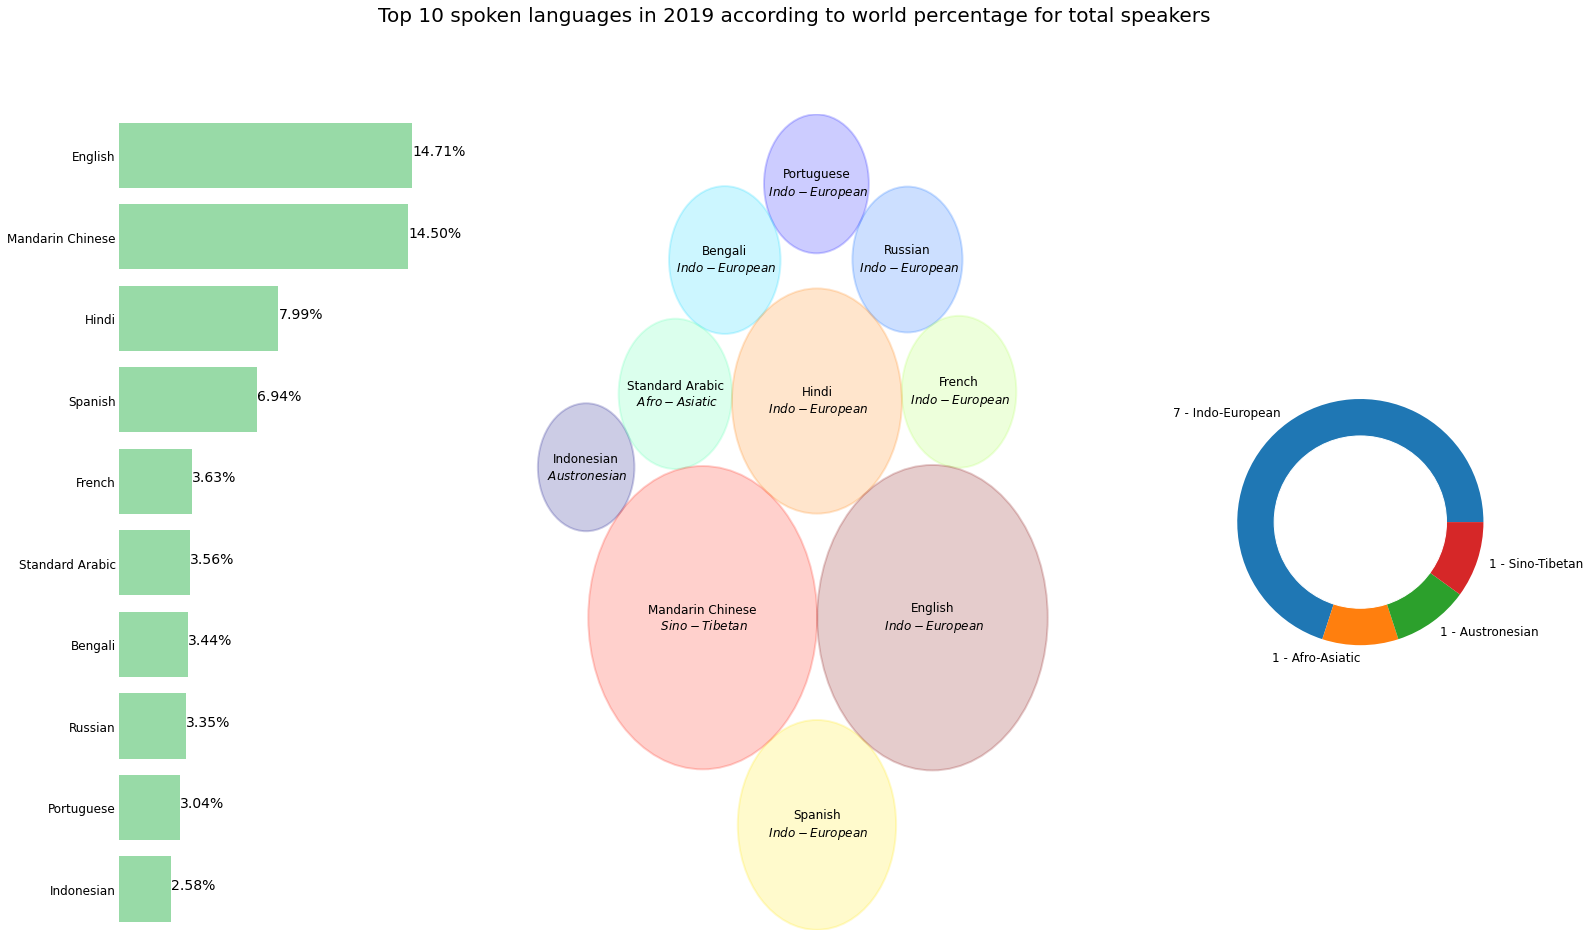

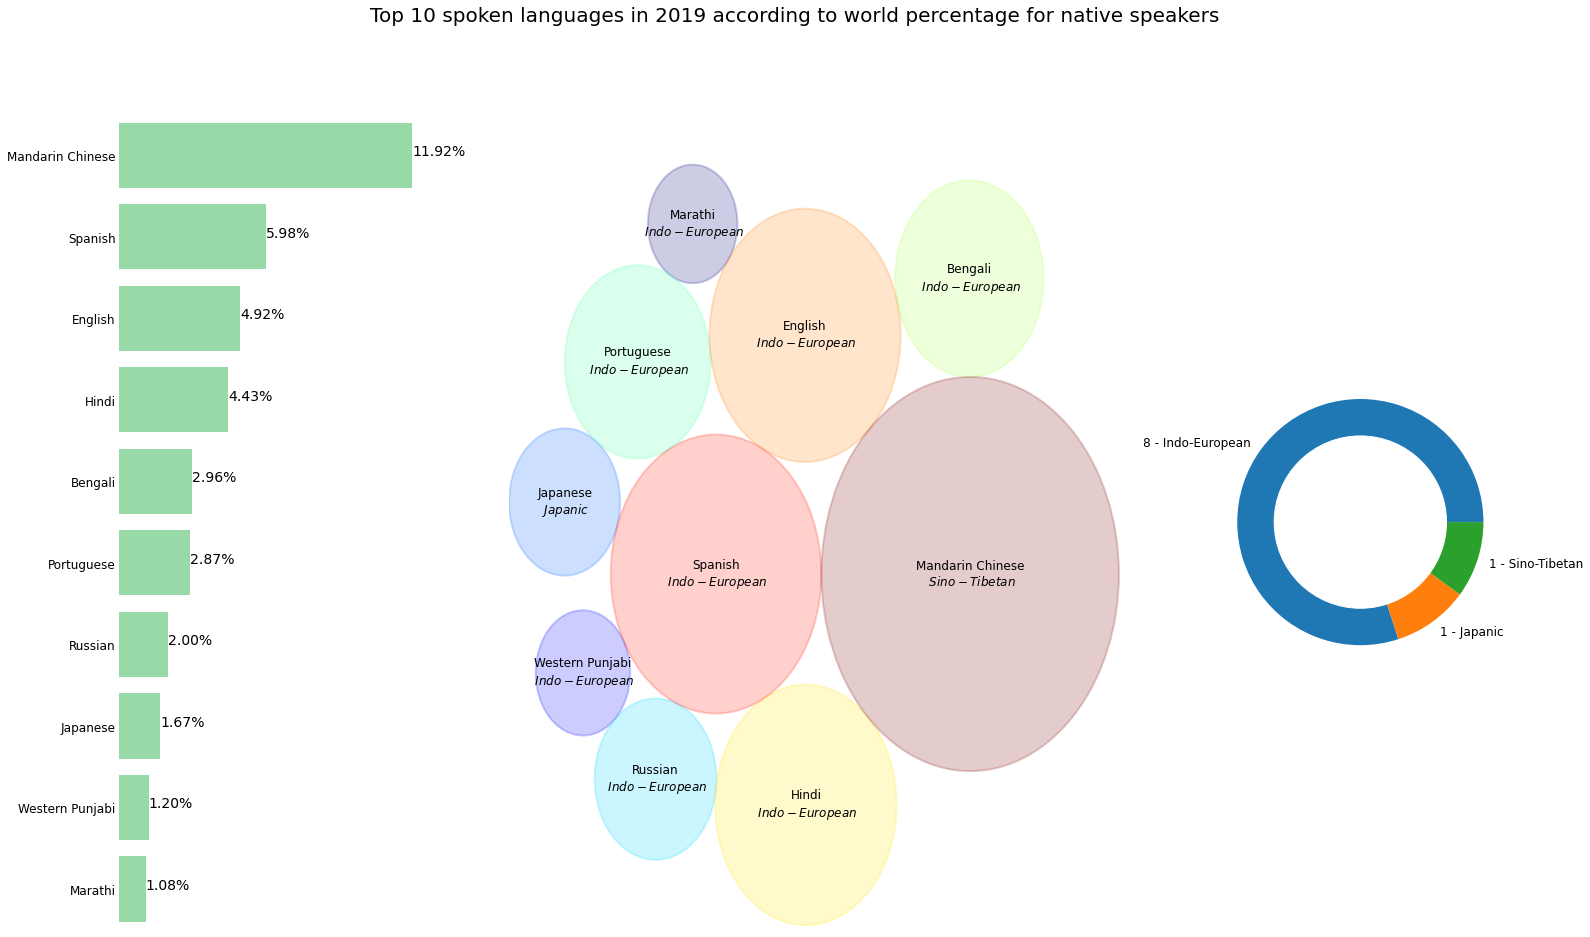

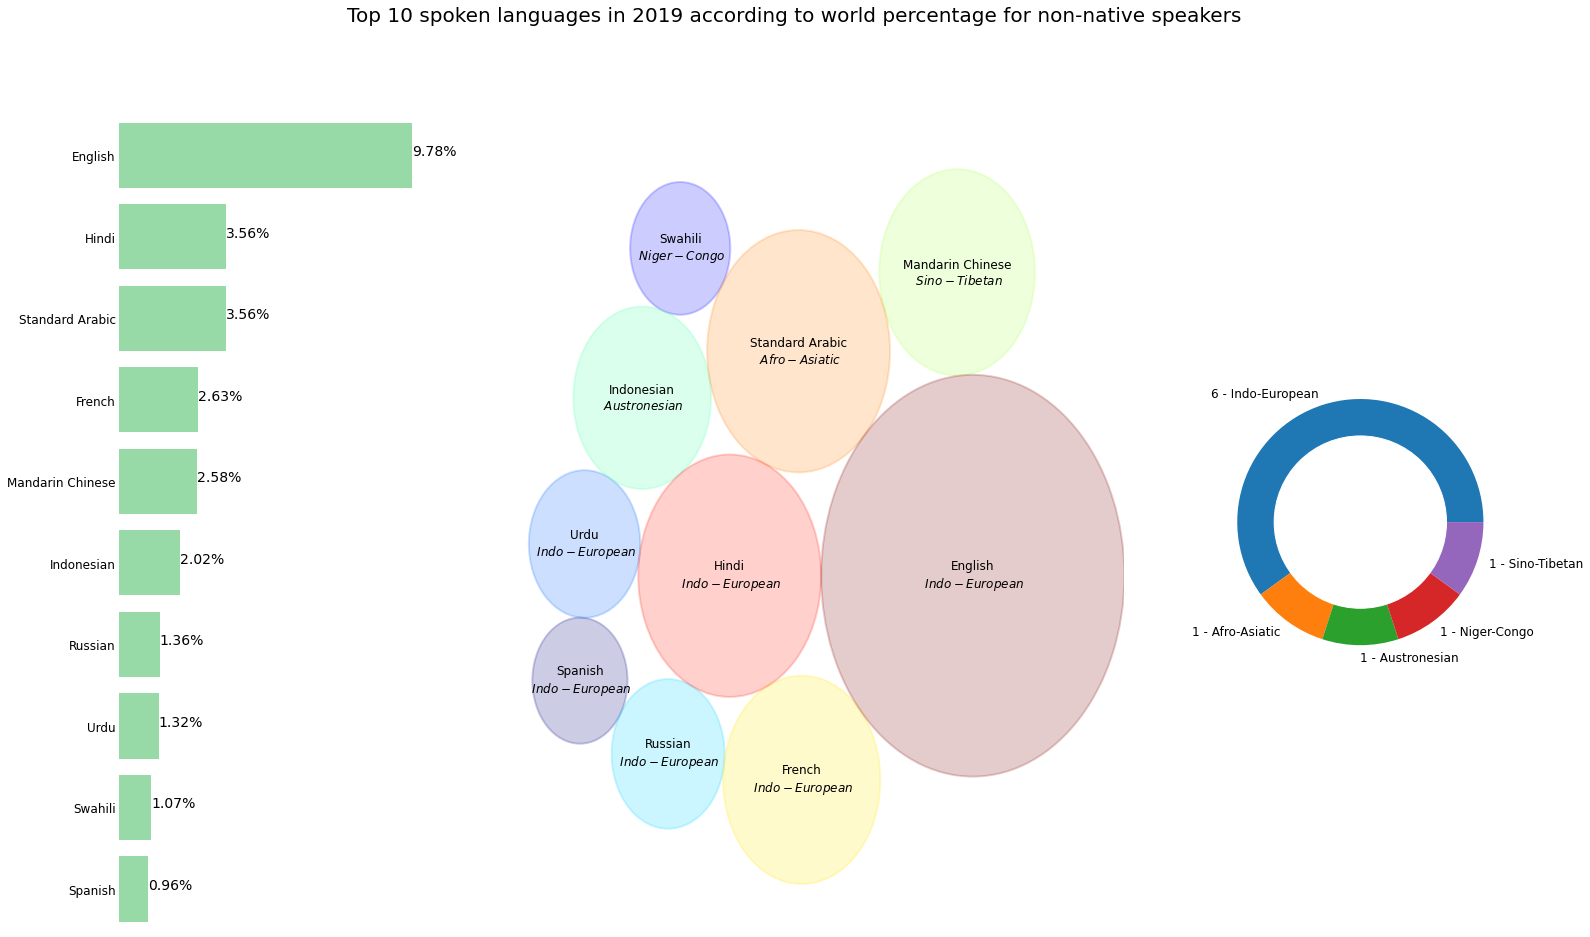

In [80]:
# Get the visualisation for world percentage total speakers (5), native (6), and non-native (7)
getVisu(5)
print("")
getVisu(6)
print("")
getVisu(7)

## 3. Report the findings

One fast efficient way to document the analysis is to use directly the jupyter notebook as support. Note that this notebook can be exported in HTML and PDF format using additional libraries. 

We remind below the initial questions:

1. What is the top 10 most spoken languages in total, by native people, and by non-native in 2019?
2. How much percentage of the world population are speaking at least one of the top 10 languages as native or non-native? For the top 100?
3. What is the origin of the top 10 most spoken languages in total, by native people, and by non-native in 2019? 

The first one and second questions are directly answered by the corresponding barplot. The third one is answered by the circular packing to identify the origin of each individual language and the donut plot give a quantified perspective of the language origin for the respective top 10.

## Possible extensions
- Explore the conversion of the jupyter notebook into another format as indicated above
- Consider to make the color of the barplot corresponding to the ones of the circular packing in order to ease the analyis